In [3]:
import shutil
import os

if os.path.exists("logs"):
    shutil.rmtree("logs")
    print("Logs directory cleared")
else:
    print("No logs directory found")

No logs directory found


In [4]:
from utils import start_tensorboard

start_tensorboard()

⚠️  Warning: Logs directory not found at /workspaces/LectureNotesNDL3/exercise_10/logs


# Convolutional Neural Networks: Image Classification with CNNs
Moving beyond fully connected networks, we explore Convolutional Neural Networks (CNNs) designed specifically for image data. CNNs preserve spatial structure through convolutional layers, pooling operations, and hierarchical feature learning.

In [5]:
# load data
import keras
import numpy as np


(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


X_train_scaled = X_train.astype("float32") / 255.0
X_test_scaled = X_test.astype("float32") / 255.0


y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")

X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


## The issues with fully connected dense networks for images
In the previous lecture we worked with small and very stable images of clothing as well. However, as previously discussed, this has a few major downsides as we increase image size and scene complexity. Even though we will stay with the fashion dataset for the introduction of our CNN layer types, I want you already to take a look at what happens to the number of parameters of a dense NN when using the **standard** image size of many more complex datasets, 224x224 pixels. (Quite small by modern standards, right?)

So please everyone build a non-functional model consisting of just an input layer with the flattened dimensions of 224*224 and a single dense layer of 256 neurons. (Tell me what you see!)

Then think about what happens with convolutional (2D) layers. Does the number of parameters grow in the same way? What about color images?

In [6]:
from keras.layers import Input, Dense
from keras.models import Model
inputs = Input((224*224,))
x = Dense(256, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

W0000 00:00:1770897059.761756    7163 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1770897059.764850    7163 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1770897059.920177    7163 gpu_device.cc:2043] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8854 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:06:00.0, compute capability: 12.0a


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,878,208 (49.13 MB)

 Trainable params: 12,878,208 (49.13 MB)

 Non-trainable params: 0 (0.00 B)

## Calculate by Hand: CNN Architecture
Lets take a look at a small convolutional neural network and how to think about parameters, as well as input and output shapes for this.

**Task:** Calculate parameters and output shapes for each layer. Does input size affect parameter count?

**Conv2D parameters:** `(kernel_h × kernel_w × input_channels + 1) × filters`

**Output shape:** Depends on kernel size, stride, padding (`same` preserves size, `valid` shrinks).

**Key:** What about different image sizes for inputs? How does the number of parameters change?

| Layer | Input Shape | Filters (C_out) | Kernel Size | Stride | Padding | Output Shape = ? | Params = ? |
|-------|-------------|-----------------|-------------|--------|---------|------------------|------------|
| Conv1 | 32 × 32 × 3 | 8 | 3 × 3 | 1 | same | ? | ? |
| Conv2 | (output of Conv1) | 16 | 3 × 3 | 1 | valid | ? | ? |
| Conv3 | (output of Conv2) | 4 | 5 × 5 | 1 | valid | ? | ? |

In [7]:
from keras.layers import Conv2D

#what about inpout size of images now? does it matter in terms of paramters of our network?
inputs = Input(shape=(32, 32, 3))
x = Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding="same", name="conv1")(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="valid", name="conv3")(x)
outputs = Conv2D(filters=4, kernel_size=(5, 5), strides=1, padding="valid", name="conv4")(x)
# what exactly is the output of this
model_ = Model(inputs=inputs, outputs=outputs)
model_.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 30, 30, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 26, 26, 4)      │         1,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996 (11.70 KB)

 Trainable params: 2,996 (11.70 KB)

 Non-trainable params: 0 (0.00 B)

## Add Classification Head
This is fine and all, but how do we actually get this to output probabilities of our classes we want to predict?
For this we introduce a new layer type:
### Flatten Layer
Converts 2D feature maps (height × width × channels) to 1D vector for Dense layers. Example: (24 Height, 24 Width, 64 Feature Maps) → (36864,)= a long 1d feature array. No trainable parameters.
We can then do a typical dense layer to down project into more compact feature representations and finally use the same dense output layer as last time with the fcnn.

What do you notice in terms of parameters now for our final model?


In [8]:
from keras.layers import Conv2D, Flatten, Dense

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)

#flatten the final feature maps into a 1d feature vector/array
x = Flatten()(x)
x = Dense(128, activation='relu')(x) # down projection
outputs = Dense(10, activation='softmax')(x)  # 10 classes

model_ = Model(inputs=inputs, outputs=outputs)
model_.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,738,826 (18.08 MB)

 Trainable params: 4,738,826 (18.08 MB)

 Non-trainable params: 0 (0.00 B)

### MaxPooling Layer

Reduces spatial dimensions by taking maximum value in each pooling window. Decreases computation, adds **some minor** translation invariance, controls overfitting.

**Key parameters:**
- `pool_size`: Window size (e.g., (2,2))
- `strides`: Default = pool_size
- `padding`: Usually "valid"

**Effect:** (28, 28, 32) with pool_size=(2,2) → (14, 14, 32). Channels unchanged, spatial dims halved. No trainable parameters.

Question: What happens to the parameter count? Where does the big effect come from?


In [9]:
from keras.layers import MaxPooling2D, Dropout, GlobalAveragePooling2D


inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample 
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample again

x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'] 
    )
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,786 (1.04 MB)

 Trainable params: 271,786 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

W0000 00:00:1770897063.082697    7163 cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.
W0000 00:00:1770897063.703472    7163 cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1770897066.943858    7285 service.cc:153] XLA service 0x79d5f00337a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770897066.943894    7285 service.cc:161]   StreamExecutor [0]: NVIDIA GeForce RTX 5070, Compute Capability 12.0a (Driver: 13.1.0; Runtime: 12.8.0; Toolkit: 12.5.0; DNN: 9.10.2)
I0000 00:00:1770897066.972519    7285 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770897067.185967    7285 cuda_dnn.cc:461] Loaded cuDNN version 91002
I0000 00:00:1770897067.221661    7285 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_2474__.33
I0000 00:00:1770897067.637600    7390 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_8', 12 bytes spill stores, 12 bytes spill loads

E0000 00:00:1770897067.661873    7382 cuda_timer.cc:87] Delay kernel timed out:

  45/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1290 - loss: 2.2898

I0000 00:00:1770897070.712218    7285 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1239/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3191 - loss: 1.8323

W0000 00:00:1770897075.310533    7163 cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
W0000 00:00:1770897075.459064    7163 cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
E0000 00:00:1770897077.412093    7770 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770897077.554761    7762 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4099 - loss: 1.6044 - val_accuracy: 0.5367 - val_loss: 1.2989
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5750 - loss: 1.1920 - val_accuracy: 0.6170 - val_loss: 1.0741
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6539 - loss: 0.9881 - val_accuracy: 0.6893 - val_loss: 0.8945
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6986 - loss: 0.8577 - val_accuracy: 0.7051 - val_loss: 0.8344
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7268 - loss: 0.7733 - val_accuracy: 0.7311 - val_loss: 0.7826
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7494 - loss: 0.7145 - val_accuracy: 0.7138 - val_loss: 0.8183
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7720 - loss: 0.6477 - val_accuracy: 0.7274 - val_loss: 0.8016
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7894 - loss: 0.5903 - val_accura

W0000 00:00:1770897124.431998    7163 cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.



  CIFAR-10 CNN - Classification Results
  Test Loss:     0.8024
  Test Accuracy: 0.7299 (72.99%)

              precision    recall  f1-score   support

    airplane       0.68      0.83      0.75      1000
  automobile       0.84      0.89      0.86      1000
        bird       0.66      0.59      0.62      1000
         cat       0.52      0.58      0.55      1000
        deer       0.65      0.74      0.69      1000
         dog       0.73      0.52      0.60      1000
        frog       0.84      0.75      0.79      1000
       horse       0.72      0.82      0.77      1000
        ship       0.87      0.80      0.83      1000
       truck       0.86      0.79      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



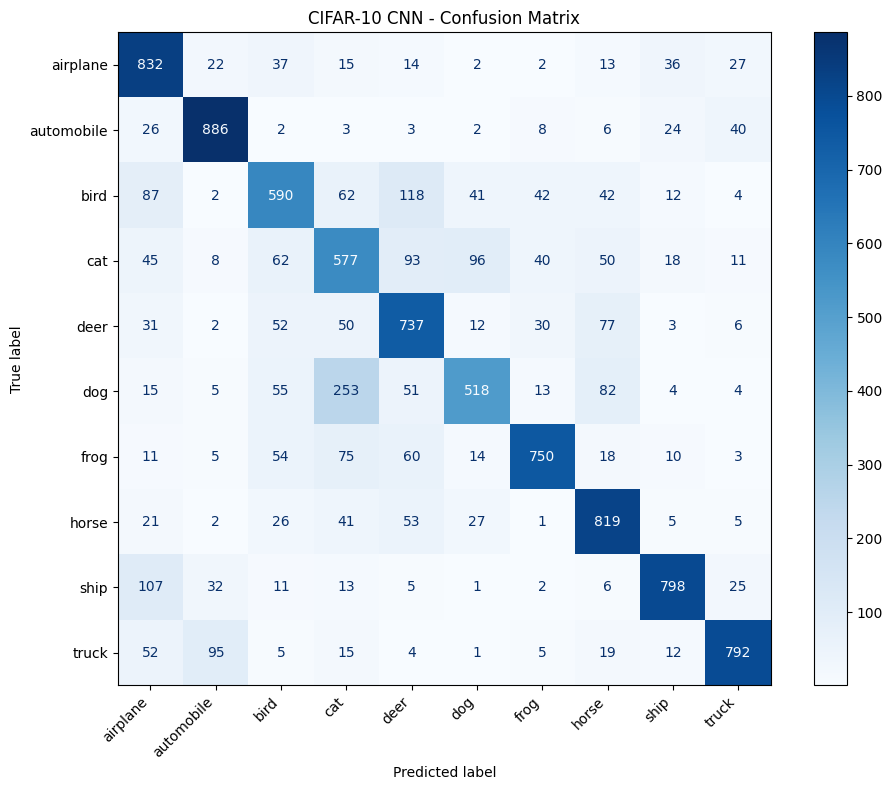

(0.8024204969406128, 0.7299000024795532)

In [10]:
# train and eval on test set
from utils import train_model, eval_classification

basic_cnn_history = train_model(model, X_train_scaled, y_train, "basic_Conv_Net_CIFAR10", epochs=10)
eval_classification(model, X_test_scaled, y_test, class_names, "CIFAR-10 CNN")

## Data Augmentation

For most modern networks that are actually used in production, architecture is not the defining factor - high quality data, and how well it captures the real world problem, is. Often the process of sampling data, getting images etc. is expensive and we cant always have the amount of data we need to train a NN well. 

One mitigation in computer vision is a set data augmentation strategies that mostly consist of **simple affine tranformations** of our input images. This is often:
- Random Crop, Flip, Zoom
- Random Translation (shifting)
- Color or Brightness Jitter

**The cool thing is that we apply those tranformations dynamically to each new batch randomly.**

Lets look at how keras does this with a set of augmentation layers.

NOTE: When we choose augmentations we should always think about what makes sense in a real world setting - which augmentations could exist when we use the model later for prediction? (e.g. compare Horizontal vs Vertical Flip) 

https://keras.io/api/layers/preprocessing_layers/

In [11]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

augmented_images = data_augmentation(X_train[:12])
augmented_images = augmented_images.numpy().astype(np.uint8)

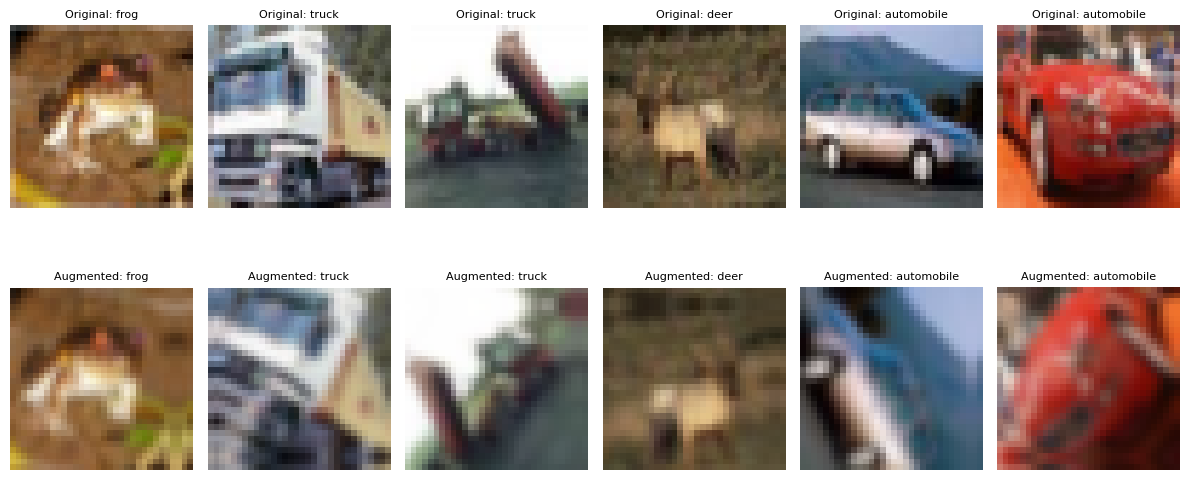

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 6, figsize=(12, 6))
for i in range(6):

    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title(f"Original: {class_names[y_train[i]]}", fontsize=8)
    axes[0, i].axis('off')
    

    axes[1, i].imshow(augmented_images[i].astype(np.uint8))
    axes[1, i].set_title(f"Augmented: {class_names[y_train[i]]}", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.3114 - loss: 1.8728 - val_accuracy: 0.4106 - val_loss: 1.6266
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3947 - loss: 1.6570 - val_accuracy: 0.4355 - val_loss: 1.5687
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4430 - loss: 1.5466 - val_accuracy: 0.5091 - val_loss: 1.3758
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4694 - loss: 1.4623 - val_accuracy: 0.5473 - val_loss: 1.2815
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5011 - loss: 1.3951 - val_accuracy: 0.5180 - val_loss: 1.4297
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5207 - loss: 1.3435 - val_accuracy: 0.5308 - val_loss: 1.3748
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5338 - loss: 1.3118 - val_accuracy: 0.5676 - val_loss: 1.2144
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5419 -

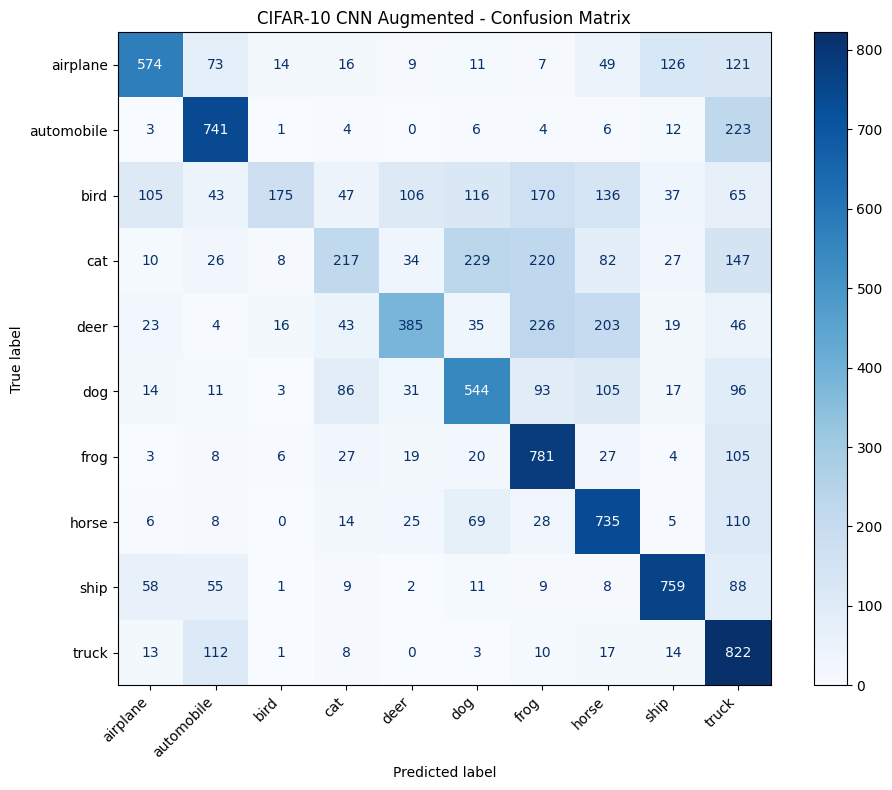

(1.2154302597045898, 0.5733000040054321)

In [13]:
inputs = Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=outputs)
model_aug.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

aug_history = train_model(model_aug, X_train_scaled, y_train, "cnn_augmented_cifar10", epochs=10)
eval_classification(model_aug, X_test_scaled, y_test, class_names, "CIFAR-10 CNN Augmented")

## Transfer Learning

In [14]:
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,  
    weights="imagenet",
    input_shape=(32, 32, 3),  
    pooling=None
)

base_model.trainable = True
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)  
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)
model_effnet = Model(inputs=inputs, outputs=outputs)
model_effnet.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
model_effnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1, 1, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,281,434 (23.96 MB)

 Trainable params: 6,220,826 (23.73 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
from utils import train_model, eval_classification

effnet_history = train_model(model_effnet, X_train, y_train, "effnetb0_cifar10", epochs=25)
eval_classification(model_effnet, X_test, y_test, class_names, "CIFAR-10 EfficientNetB0")

Epoch 1/25


E0000 00:00:1770897369.767436    7163 meta_optimizer.cc:969] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_6_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 281s 203ms/step - accuracy: 0.4457 - loss: 1.5991 - val_accuracy: 0.5857 - val_loss: 1.2355
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 256s 205ms/step - accuracy: 0.5680 - loss: 1.2811 - val_accuracy: 0.6044 - val_loss: 1.1487
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 278s 223ms/step - accuracy: 0.6004 - loss: 1.1875 - val_accuracy: 0.6331 - val_loss: 1.0554
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 289s 231ms/step - accuracy: 0.6221 - loss: 1.1299 - val_accuracy: 0.6546 - val_loss: 1.0491
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 274s 219ms/step - accuracy: 0.6479 - loss: 1.0677 - val_accuracy: 0.6753 - val_loss: 0.9429
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6603 - loss: 1.0226